# Table of contents

# Load libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from spectral import envi, imshow

import pickle
import webcolors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')
from matplotlib import colors

sns.set(font_scale=1.6) #for label size

## Load data

Insert name of folder containing data_files and scripts here

In [2]:
folder = ''

In [3]:
data_path = Path(folder)

data_files = 'Data_files'
data_files_path = data_path / data_files

KMeans_data_folder = 'Data_classification_results/KMeans data'
KMeans_data_path = data_path / KMeans_data_folder

bands_folder = 'Data_classification_results/Data pre-treatment'
bands_path = data_path / bands_folder

model_folder = 'Data_classification_results/Model creation'
model_path = data_path / model_folder 

results_folder = 'Data_classification_results/Model prediction'
results_path = data_path / results_folder
results_path.mkdir(parents=True, exist_ok = True)
os.chdir(results_path)

### Processing functions

In [4]:
def process_hdr_files(data_path):
    data = {}
    
    hdr_files = [x for x in data_path.iterdir() if x.suffix == '.hdr' and x.stem.endswith('_processed')]
    
    for hdr_file in tqdm(hdr_files):
        name = " ".join(re.findall('(.*?)\_processed', hdr_file.stem))

        try:
            X = envi.open(hdr_file.as_posix()).load()
            cleaned_X = np.where(X > 1, 0, X.copy()) # Create a modified copy of the array to change over-exposed pixels to 0     
            data[name] = cleaned_X
            
        except Exception as e:
            print(f"Error while loading data from '{hdr_file}': {e}")
            
    return data

def import_SAM_class_img(data_path):
    SAM_imgs = {}
    
    SAM_img_files = [x for x in data_path.iterdir() if x.suffix == '.png' and x.stem.endswith('_class_image')]
    
    for img_file in tqdm(SAM_img_files):
        name = " ".join(re.findall('(.*?)\_class_image', img_file.stem))
        
        try:
            Y = Image.open(img_file)
            
            SAM_imgs[name] = Y
            
        except FileNotFoundError as e:
            print(f"Error: File '{img_file}' not found: {e}")
        except OSError as e:
            print(f"Error while opening image '{img_file}': {e}")
            
    return SAM_imgs

def import_kmeans_gt(data_path):
    kmeans_data = {}
    
    kmeans_files = [x for x in data_path.iterdir() if x.suffix == '.csv' and x.stem.startswith('kmeans_img')]
    
    for img_file in tqdm(kmeans_files):
        name = " ".join(re.findall('kmeans_img_(.*)', img_file.stem))
        
        try:
            Q = pd.read_csv(img_file, index_col = 0)
            Q = Q.values.astype('uint8')
            
            kmeans_data[name] = Q
        
        except FileNotFoundError as e:
            print(f"Error: File '{img_file}' not found: {e}")
            
    return kmeans_data

### Process data

In [5]:
# Call the function to process the '.hdr' files and populate the data dictionary
data = process_hdr_files(data_files_path)  

# Call the function to process the class image files and populate the data dictionary
SAM_imgs = import_SAM_class_img(data_files_path)
kmeans_data = import_kmeans_gt(KMeans_data_path)

100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


### Load one file for metadata and wavelengths

In [6]:
def get_wl(data_path):
    
    hdr_files = [x for x in data_files_path.iterdir() if x.suffix == '.hdr' and x.stem.endswith('_processed')]

    for file in hdr_files:
        data_file = envi.open(file.as_posix()).load()
        break
    
    wl_list = np.array(data_file.metadata['wavelength'])
    wl = np.array([float(wavelength) for wavelength in wl_list])
    del data_file
    
    return wl

In [7]:
wl = get_wl(data_files_path)

In [8]:
print(wl)

[470.        472.885906  475.7718121 478.6577181 481.5436242 484.4295302
 487.3154362 490.2013423 493.0872483 495.9731544 498.8590604 501.7449664
 504.6308725 507.5167785 510.4026846 513.2885906 516.1744966 519.0604027
 521.9463087 524.8322148 527.7181208 530.6040268 533.4899329 536.3758389
 539.261745  542.147651  545.033557  547.9194631 550.8053691 553.6912752
 556.5771812 559.4630872 562.3489933 565.2348993 568.1208054 571.0067114
 573.8926174 576.7785235 579.6644295 582.5503356 585.4362416 588.3221477
 591.2080537 594.0939597 596.9798658 599.8657718 602.7516779 605.6375839
 608.5234899 611.409396  614.295302  617.1812081 620.0671141 622.9530201
 625.8389262 628.7248322 631.6107383 634.4966443 637.3825503 640.2684564
 643.1543624 646.0402685 648.9261745 651.8120805 654.6979866 657.5838926
 660.4697987 663.3557047 666.2416107 669.1275168 672.0134228 674.8993289
 677.7852349 680.6711409 683.557047  686.442953  689.3288591 692.2147651
 695.1006711 697.9865772 700.8724832 703.7583893 70

### Integration times

In [9]:
int_times = {}
hdr_files = [x for x in data_files_path.iterdir() if x.suffix == '.hdr' and x.stem.endswith('_processed')]

for file in hdr_files:
    name = " ".join(re.findall('(.*?)\_processed', file.stem))
    data_file = envi.open(file.as_posix()).metadata['integration time']
    int_times[name] = data_file

integ = pd.DataFrame.from_dict(int_times, orient = 'index')
integ.reset_index(inplace = True)
integ = integ.rename(columns = {'index' : 'ID', 0 : 'integration time'})
integ.set_index('ID', inplace = True)
integ.to_excel('integration_times.xlsx')

### Load models

In [10]:
model_files = [x for x in model_path.iterdir() if x.suffix == '.csv' and x.stem.endswith('model')]
    
for file in tqdm(model_files):
    if file.stem.startswith('SAM'):  
        SAM_model = pickle.load(open(file, 'rb'))
    if file.stem.startswith('kmeans'):  
        kmeans_model = pickle.load(open(file, 'rb'))

100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


### Load selected bands

In [11]:
band_files = [x for x in bands_path.iterdir() if x.suffix == '.csv' and x.stem.endswith('bands')]

for file in band_files:
    if file.stem.startswith('SAM'):
        SAM_selected_bands = np.array(pd.read_csv(file)).ravel()
    if file.stem.startswith('kmeans'):
        kmeans_selected_bands = np.array(pd.read_csv(file)).ravel()

In [12]:
print(SAM_selected_bands)
print(kmeans_selected_bands)

['band5' 'band7' 'band10' 'band16' 'band19' 'band24' 'band28' 'band32'
 'band36' 'band39' 'band44' 'band47' 'band51' 'band55' 'band59' 'band64'
 'band69' 'band75' 'band79' 'band85' 'band90' 'band95' 'band102' 'band108'
 'band116' 'band122' 'band128' 'band134' 'band140']
['band4' 'band16' 'band19' 'band25' 'band28' 'band32' 'band36' 'band39'
 'band47' 'band51' 'band55' 'band60' 'band65' 'band70' 'band75' 'band79'
 'band84' 'band95' 'band101' 'band107' 'band116' 'band123' 'band128'
 'band134' 'band140']


### Data contents

In [13]:
print(data.keys())
print(SAM_imgs.keys())
print(kmeans_data.keys())

dict_keys(['A2', 'D2'])
dict_keys(['A2', 'D2'])
dict_keys(['A2', 'D2'])


#### Data shape

In [14]:
print(data['A2'].shape)
print(SAM_imgs['A2'].size)
print(kmeans_data['A2'].shape)

(1528, 2048, 150)
(2048, 1528)
(1528, 2048)


### Functions to extract data

In [15]:
def extract_gt_pixels(y, shape1, shape2):
    
    def get_colour_name(rgb_triplet):
        min_colours = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - rgb_triplet[0]) ** 2
            gd = (g_c - rgb_triplet[1]) ** 2
            bd = (b_c - rgb_triplet[2]) ** 2
            min_colours[(rd + gd + bd)] = name
        return min_colours[min(min_colours.keys())]
    
    y_data = list(y.getdata())
    color_dict = {}
    for x in set(y_data):
         color_dict[x] = get_colour_name(x)

    color_dict[(0, 0, 0, 0)] =  'white'  
    class_dict = {'white' : '0', 'black' : '1', 'mediumvioletred' : '2', 'gold' : '3'}
            # white - unlabelled, black - soil, magenta - mixed, yellow - root

    color_pixels = [color_dict[k] for k in y_data]
    
    pixel_labels = np.array([class_dict.get(k, 0) for k in color_pixels])
    
    gt = pixel_labels.reshape((shape1, shape2)).astype('uint8')
    
    return gt

In [16]:
def get_dict_name(some_dict):
    dict_name = [name for name, obj in globals().items() if obj is some_dict]
    return dict_name[0]

In [17]:
def hypercube_to_df(df_dict, data_name):

    # 3D hypercube to 2D dataframe
    X = df_dict[data_name]
    df = pd.DataFrame(X.reshape(X.shape[0]*X.shape[1], -1))
    df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
    return(df)

def reduce_bands(df, bands): 
    df = df[bands]
    return(df)

def assign_labels(df, gt):
    new_df = df.assign(Class=gt.ravel())
#     new_df['Class'] = gt.ravel()  
    return(new_df)

In [18]:
def df_SAM_labels(df_dict, img_dict, data_name, bands, shape1, shape2):
    
    df = hypercube_to_df(df_dict, data_name)
    df = reduce_bands(df, bands)

    # Extract SAM class image pixel labels
    gt = extract_gt_pixels(img_dict[data_name], shape1, shape2)
    
    df = assign_labels(df, gt)

    return(df)  

In [19]:
def df_kmeans_labels(df_dict, img_dict, data_name, bands, shape1, shape2):
    
    df = hypercube_to_df(df_dict, data_name)
    df = reduce_bands(df, bands)
        
    # Extract kmeans class image pixel labels
    gt = img_dict[data_name]
        
    df = assign_labels(df, gt)
    df['Class'] = df['Class'].replace({2 : 3, 1 : 2, 0 : 1})
    
    return(df)  

In [20]:
def hypercube_to_df_selected_bands(df_dict, data_name, bands):

    # Hypercube dataframe
    X = df_dict[data_name]
    df = pd.DataFrame(X.reshape(X.shape[0]*X.shape[1], -1))
    df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
    
    # Reduce dataframe to selected bands for model prediction
    df = df[bands]

    return(df) 

In [21]:
def df_SAM_labels(df_dict, img_dict, data_name, bands, shape1, shape2):
    
    df = hypercube_to_df_selected_bands(df_dict, data_name, bands)

    # Extract SAM class image pixel labels
    gt = extract_gt_pixels(img_dict[data_name], shape1, shape2)
    
    # Assign classification columns
    df['SAM_class'] = gt.ravel()

    return(df)  

In [22]:
def df_kmeans_labels(df_dict, img_dict, data_name, bands, shape1, shape2):
    
    df = hypercube_to_df_selected_bands(df_dict, data_name, bands)
        
    # Extract kmeans class image pixel labels
    kmeans_gt = img_dict[data_name]
        
    # Assign classification columns
    df['kmeans_class'] = kmeans_gt.ravel()
    df['kmeans_class'] = df['kmeans_class'].replace({2 : 3, 1 : 2, 0 : 1})
    
    return(df)  

### Extract all data and store in a dictionary

In [23]:
SAM_df = {}
kmeans_df = {}

for key in data.keys():
    temp_df = df_SAM_labels(data, SAM_imgs, key, SAM_selected_bands, shape1 = 1528, shape2 = 2048)
    SAM_df[key] = temp_df

for key in data.keys():
    temp_df = df_kmeans_labels(data, kmeans_data, key, kmeans_selected_bands, shape1 = 1528, shape2 = 2048)
    kmeans_df[key] = temp_df

In [24]:
print(SAM_df.keys())
print(kmeans_df.keys())

dict_keys(['A2', 'D2'])
dict_keys(['A2', 'D2'])


In [25]:
print(SAM_df['A2'].shape)
print(kmeans_df['A2'].shape)

(3129344, 30)
(3129344, 26)


In [26]:
kmeans_df['A2'].head()

,band4,band16,band19,band25,band28,band32,band36,band39,band47,band51,...,band84,band95,band101,band107,band116,band123,band128,band134,band140,kmeans_class
0,0.056587,0.064558,0.077488,0.070252,0.063401,0.066125,0.057206,0.073126,0.058076,0.095638,...,0.112598,0.147477,0.161403,0.189097,0.211936,0.218318,0.240677,0.256566,0.264626,1
1,0.060830,0.029167,0.028477,0.088563,0.040015,0.047265,0.060637,0.040978,0.057432,0.081845,...,0.112835,0.143291,0.155240,0.171576,0.197420,0.207798,0.232698,0.239895,0.260330,1
2,0.039852,0.080663,0.072622,0.093017,0.063506,0.062638,0.063194,0.074050,0.074901,0.076102,...,0.107029,0.142309,0.187302,0.176672,0.214069,0.219153,0.239684,0.251832,0.272784,1
3,0.054648,0.067730,-0.007787,0.078364,0.075775,0.023819,0.071205,0.070303,0.077622,0.093130,...,0.128394,0.165955,0.187589,0.206126,0.227217,0.256727,0.266511,0.267489,0.294580,1
4,0.012257,0.046201,0.056069,0.114238,0.062291,0.057879,0.058844,0.058553,0.083528,0.104027,...,0.152472,0.175767,0.201140,0.213429,0.231072,0.253819,0.269232,0.283898,0.292095,2


## Model prediction

In [27]:
def return_rf_prediction(model, data_dict, key, shape1, shape2):
    
    model_name = " ".join(re.findall('(.*)\_model', get_dict_name(model)))
    
    temp_df = data_dict[key].copy()

    df = temp_df.iloc[:, :].values
    
    # Color map for spectral classes: black = soil, magenta = mixed, yellow = root
    cmap = colors.ListedColormap(['#000000', '#cc0066', '#ffcc00'])
    
    ## RF model
    rf_result = model.predict(df) 
    
    ## prediction
    predicted_rf_data = rf_result.reshape((shape1, shape2)).astype(np.int8)
    pred_df = pd.DataFrame(predicted_rf_data)
    
    fig, ax = plt.subplots()
    plt.grid(False)
    ax.imshow(predicted_rf_data, cmap = cmap)
    plt.axis('off')
    
    pred_df.to_csv(key + '_' + model_name + '_RF_predicted_img.csv')
    plt.savefig(key + '_' + model_name + '_RF_predicted_whole_image.png', dpi = 300, bbox_inches = 'tight')
    plt.close()
    
    print(key + ': Done')

In [28]:
class_reports = pd.DataFrame()
predicted_imgs = {}


def return_rf_accuracy(model, data_dict, key, shape1, shape2):
    
    global class_reports
    global predicted_imgs
    
    model_name = " ".join(re.findall('(.*)\_model', get_dict_name(model)))
    
    temp_df = data_dict[key].copy()

    df = temp_df.iloc[:, :-1].values
    labels = temp_df.iloc[:, -1].values.astype('uint8')
    SAM_names = ['Unlabelled', 'Soil', 'Mixed', 'Root']
    names = ['Soil', 'Mixed', 'Root']
    
    cmap = colors.ListedColormap(['#000000', '#cc0066', '#ffcc00'])
    
    ## RF model
    rf_result = model.predict(df)
    
    
    ## prediction
    predicted_rf_data = rf_result.reshape((shape1, shape2)).astype(np.int8)
    pred_df = pd.DataFrame(predicted_rf_data)
    predicted_imgs[key + '_' + model_name] = pred_df
    
    fig, ax = plt.subplots()
    plt.grid(False)
    ax.imshow(predicted_rf_data, cmap = cmap)
    plt.axis('off')
   
    pred_df.to_csv(key + '_' + model_name + '_RF_predicted_img.csv')
    plt.savefig(key + '_' + model_name + '_RF_predicted_whole_image.png', dpi = 300, bbox_inches = 'tight')
    plt.close()
   

    ## classification
    SAM_rf_report = pd.DataFrame(classification_report(labels, rf_result, output_dict = True)).round(2).transpose()
    SAM_rf_report['Sample'] =  key
    SAM_rf_report['Model'] = model_name
       
    SAM_rf_report.reset_index(inplace = True)
    SAM_rf_report.rename(columns = {'index' : 'Class'}, inplace = True)
    SAM_rf_report.set_index(['Model', 'Sample', 'Class'], inplace = True)

    class_reports = pd.concat([class_reports, SAM_rf_report])

    
    ## SAM labels confusion matrix
    if model_name == 'SAM':
    
        SAM_df_cm = pd.DataFrame(confusion_matrix(labels, rf_result), columns = SAM_names, index = SAM_names) 
        SAM_df_cm.index.name = 'Actual'
        SAM_df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,8))
        plt.title('SAM RF Confusion Matrix', fontsize = '20')
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(SAM_df_cm, cmap = 'copper', annot=True,annot_kws={"size": 16}, fmt='d')

        plt.savefig(key + '_' + model_name +'_RF_confusion_matrix.png', dpi = 300)
        plt.close()
    
    if model_name == 'kmeans':
    
        kmeans_df_cm = pd.DataFrame(confusion_matrix(labels, rf_result), columns = names, index = names) 
        kmeans_df_cm.index.name = 'Actual'
        kmeans_df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,8))
        plt.title('KMeans RF Confusion Matrix', fontsize = '20')
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(kmeans_df_cm, cmap = 'copper', annot=True,annot_kws={"size": 16}, fmt='d')

        plt.savefig(key + '_' + model_name +'_RF_confusion_matrix.png', dpi = 300)
        plt.close()
    
    print(key + ': Done')
#     return(class_reports)

In [29]:
for key in list(SAM_df.keys()):
    return_rf_accuracy(SAM_model, SAM_df, key, 1528, 2048)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.9s finished
C:\Users\cfa024\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cfa024\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

A2: Done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.4s finished
C:\Users\cfa024\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cfa024\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

D2: Done


In [30]:
for key in list(kmeans_df.keys()):
    return_rf_accuracy(kmeans_model, kmeans_df, key, 1528, 2048)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.7s finished


A2: Done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.6s finished


D2: Done


In [31]:
class_reports.to_excel('Class_reports.xlsx')

### Add new prediction labels to original dataframe

In [32]:
predicted_imgs.keys()

dict_keys(['A2_SAM', 'D2_SAM', 'A2_kmeans', 'D2_kmeans'])

In [33]:
SAM_predicted_imgs = {}
kmeans_predicted_imgs = {}

for key, item in predicted_imgs.items():
    if 'SAM' in key:
            name = " ".join(re.findall('(.*?)\_SAM', key))
            SAM_predicted_imgs[name] = item

    if 'kmeans' in key:
        name = " ".join(re.findall('(.*?)\_kmeans', key))
        kmeans_predicted_imgs[name] = item

In [34]:
SAM_labelled_data = {}
kmeans_labelled_data = {}

for key, item in data.items():
    temp_df = hypercube_to_df(data, key)
    SAM_df = assign_labels(temp_df, SAM_predicted_imgs[key].values.astype('uint8'))
    kmeans_df = assign_labels(temp_df, kmeans_predicted_imgs[key].values.astype('uint8'))
    
    SAM_labelled_data[key] = SAM_df
    kmeans_labelled_data[key] = kmeans_df  

In [35]:
SAM_mean_data = {}

for key, item in SAM_labelled_data.items():
    
    temp_df = pd.DataFrame()
    
    root_spec = item[item['Class'] == 3].mean()
    mixed_spec = item[item['Class'] == 2].mean()
    soil_spec = item[item['Class'] == 1].mean()
    
    temp_df['Root'] = root_spec[0:150]
    temp_df['Mixed'] = mixed_spec[0:150]
    temp_df['Soil'] = soil_spec[0:150]
    temp_df = temp_df.T
    
    SAM_mean_data[key] = temp_df
    
kmeans_mean_data = {}

for key, item in kmeans_labelled_data.items():
    
    temp_df = pd.DataFrame()
    
    root_spec = item[item['Class'] == 3].mean()
    mixed_spec = item[item['Class'] == 2].mean()
    soil_spec = item[item['Class'] == 1].mean()
    
    temp_df['Root'] = root_spec[0:150]
    temp_df['Mixed'] = mixed_spec[0:150]
    temp_df['Soil'] = soil_spec[0:150]
    temp_df = temp_df.T
    
    kmeans_mean_data[key] = temp_df

In [37]:
SAM_predicted_spectra = pd.DataFrame()

for key, item in SAM_mean_data.items():
    
    temp_df = item.copy()
    temp_df['Species'] = key
    temp_df.reset_index(inplace = True)
    temp_df.rename({'index' : 'Class'},axis = 1, inplace = True)
    temp_df.set_index(['Species', 'Class'], inplace = True)
    SAM_predicted_spectra = pd.concat([SAM_predicted_spectra, temp_df])

SAM_predicted_spectra.reset_index(inplace = True)
SAM_predicted_spectra['Class'] = pd.Categorical(SAM_predicted_spectra['Class'], ['Root', 'Mixed', 'Soil'])    
SAM_predicted_spectra = SAM_predicted_spectra.sort_values(by = 'Class')
SAM_predicted_spectra.set_index(['Species', 'Class'], inplace = True)
SAM_predicted_spectra.to_excel('SAM_predicted_spectra.xlsx')

kmeans_predicted_spectra = pd.DataFrame()

for key, item in kmeans_mean_data.items():
    
    temp_df = item.copy()
    temp_df['Species'] = key
    temp_df.reset_index(inplace = True)
    temp_df.rename({'index' : 'Class'},axis = 1, inplace = True)
    temp_df.set_index(['Species', 'Class'], inplace = True)
    kmeans_predicted_spectra = pd.concat([kmeans_predicted_spectra, temp_df])

kmeans_predicted_spectra.reset_index(inplace = True)
kmeans_predicted_spectra['Class'] = pd.Categorical(kmeans_predicted_spectra['Class'], ['Root', 'Mixed', 'Soil'])    
kmeans_predicted_spectra = kmeans_predicted_spectra.sort_values(by = 'Class')
kmeans_predicted_spectra.set_index(['Species', 'Class'], inplace = True)    
kmeans_predicted_spectra.to_excel('kmeans_predicted_spectra.xlsx')

# Plot mean predicted spectra

#### Add same index labels as in data pre-treatment

In [38]:
SAM_predicted_spectra

,,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band141,band142,band143,band144,band145,band146,band147,band148,band149,band150
Species,Class,,,,,,,,,,,,,,,,,,,,,
A2,Root,0.263562,0.264054,0.261999,0.261468,0.262170,0.263397,0.265833,0.265603,0.265752,0.266495,...,0.394923,0.395537,0.396036,0.396377,0.396427,0.396367,0.396147,0.396106,0.396183,0.396183
D2,Root,0.209185,0.209446,0.207923,0.207706,0.208624,0.210012,0.211292,0.209798,0.209209,0.209804,...,0.290919,0.291595,0.292106,0.292487,0.292800,0.292994,0.293056,0.293449,0.293709,0.293709
A2,Mixed,0.116322,0.116647,0.114806,0.113202,0.112264,0.112611,0.114392,0.113575,0.112612,0.111374,...,0.241544,0.242985,0.244421,0.245834,0.247047,0.248279,0.249362,0.250591,0.251178,0.251178
D2,Mixed,0.073619,0.074049,0.072546,0.071529,0.071210,0.071990,0.073680,0.072672,0.071746,0.070730,...,0.154797,0.156261,0.157725,0.159218,0.160574,0.161924,0.163052,0.164345,0.164936,0.164936
A2,Soil,0.055755,0.055493,0.053431,0.051496,0.050099,0.050140,0.051504,0.049773,0.048063,0.046054,...,0.173742,0.175724,0.177841,0.180037,0.182000,0.184033,0.185895,0.187908,0.188806,0.188806
D2,Soil,0.040195,0.040378,0.038848,0.037432,0.036734,0.037610,0.039059,0.037651,0.036268,0.034637,...,0.124837,0.126623,0.128514,0.130438,0.132242,0.134051,0.135626,0.137414,0.138243,0.138243


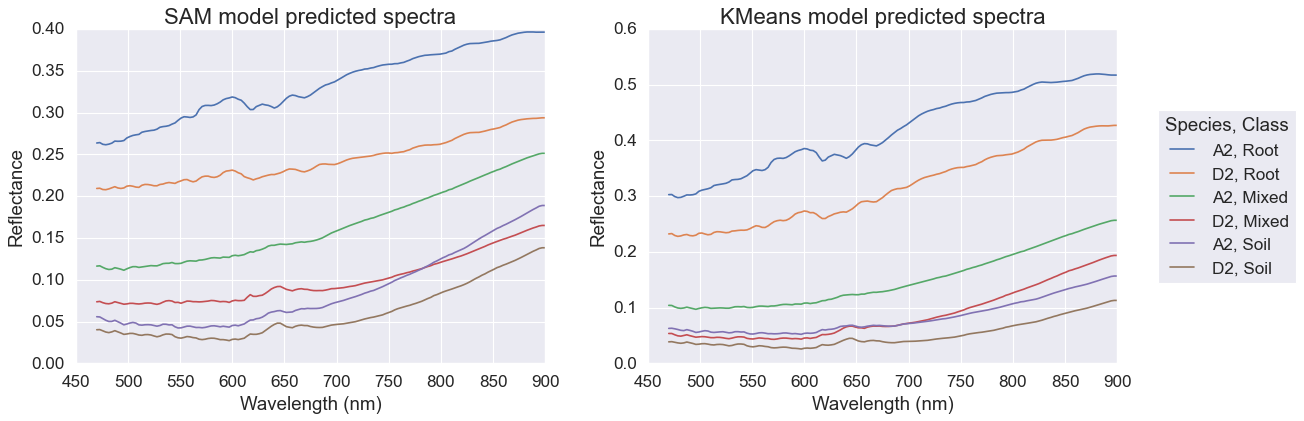

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
fig.tight_layout(pad = 3.0) 

ax[0].plot(wl, SAM_predicted_spectra.values.T)

ax[0].set_title('SAM model predicted spectra', fontsize = '20')
ax[0].set_ylabel('Reflectance')
ax[0].set_xlabel('Wavelength (nm)')

ax[1].plot(wl, kmeans_predicted_spectra.values.T)

ax[1].set_title('KMeans model predicted spectra', fontsize = '20')
ax[1].set_ylabel('Reflectance')
ax[1].set_xlabel('Wavelength (nm)')

legend_handles = SAM_predicted_spectra.reset_index()[['Species', 'Class']].astype(str).apply(', '.join, axis=1).tolist()
plt.legend(legend_handles, title = 'Species, Class', loc = 'center right', bbox_to_anchor = (1.4, 0.5))

plt.savefig('Predicted_spectra.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Run PLS-DA for correlation

#### Add model column

In [40]:
class_label_dict = {
    'Soil' : '1',
    'Mixed' : '2', 
    'Root' : '3'
}

species_label_dict = {
    'A2' : '1', 
    'D2' : '2'
}

In [41]:
SAM_predicted_spectra.reset_index(inplace = True)
SAM_predicted_spectra['Model'] = '1'
SAM_predicted_spectra['Class_label'] = SAM_predicted_spectra['Class'].map(class_label_dict)
SAM_predicted_spectra['Species_label'] = SAM_predicted_spectra['Species'].map(species_label_dict)
SAM_predicted_spectra.set_index(['Model', 'Class', 'Species', 'Class_label', 'Species_label'], inplace = True)

In [42]:
kmeans_predicted_spectra.reset_index(inplace = True)
kmeans_predicted_spectra['Model'] = '2'
kmeans_predicted_spectra['Class_label'] = kmeans_predicted_spectra['Class'].map(class_label_dict)
kmeans_predicted_spectra['Species_label'] = kmeans_predicted_spectra['Species'].map(species_label_dict)
kmeans_predicted_spectra.set_index(['Model', 'Class', 'Species', 'Class_label', 'Species_label'], inplace = True)

In [43]:
all_predicted_spectra = pd.concat([SAM_predicted_spectra, kmeans_predicted_spectra])

In [44]:
all_predicted_spectra.head()

band1     band2     band3  \
Model Class Species Class_label Species_label                                 
1     Root  A2      3           1              0.263562  0.264054  0.261999   
            D2      3           2              0.209185  0.209446  0.207923   
      Mixed A2      2           1              0.116322  0.116647  0.114806   
            D2      2           2              0.073619  0.074049  0.072546   
      Soil  A2      1           1              0.055755  0.055493  0.053431   

                                                  band4     band5     band6  \
Model Class Species Class_label Species_label                                 
1     Root  A2      3           1              0.261468  0.262170  0.263397   
            D2      3           2              0.207706  0.208624  0.210012   
      Mixed A2      2           1              0.113202  0.112264  0.112611   
            D2      2           2              0.071529  0.071210  0.071990   
      Soil  A2      1           1              0.051496  0.050099  0.050140   

                                                  band7     band8     band9  \
Model Class Species Class_label Species_label                                 
1     Root  A2      3           1              0.265833  0.265603  0.265752   
            D2      3           2              0.211292  0.209798  0.209209   
      Mixed A2      2           1              0.114392  0.113575  0.112612   
            D2      2           2              0.073680  0.072672  0.071746   
      Soil  A2      1           1              0.051504  0.049773  0.048063   

                                                 band10  ...   band141  \
Model Class Species Class_label Species_label            ...             
1     Root  A2      3           1              0.266495  ...  0.394923   
            D2      3           2              0.209804  ...  0.290919   
      Mixed A2      2           1              0.111374  ...  0.241544   
            D2      2           2              0.070730  ...  0.154797   
      Soil  A2      1           1              0.046054  ...  0.173742   

                                                band142   band143   band144  \
Model Class Species Class_label Species_label                                 
1     Root  A2      3           1              0.395537  0.396036  0.396377   
            D2      3           2              0.291595  0.292106  0.292487   
      Mixed A2      2           1              0.242985  0.244421  0.245834   
            D2      2           2              0.156261  0.157725  0.159218   
      Soil  A2      1           1              0.175724  0.177841  0.180037   

                                                band145   band146   band147  \
Model Class Species Class_label Species_label                                 
1     Root  A2      3           1              0.396427  0.396367  0.396147   
            D2      3           2              0.292800  0.292994  0.293056   
      Mixed A2      2           1              0.247047  0.248279  0.249362   
            D2      2           2              0.160574  0.161924  0.163052   
      Soil  A2      1           1              0.182000  0.184033  0.185895   

                                                band148   band149   band150  
Model Class Species Class_label Species_label                                
1     Root  A2      3           1              0.396106  0.396183  0.396183  
            D2      3           2              0.293449  0.293709  0.293709  
      Mixed A2      2           1              0.250591  0.251178  0.251178  
            D2      2           2              0.164345  0.164936  0.164936  
      Soil  A2      1           1              0.187908  0.188806  0.188806  

[5 rows x 150 columns]

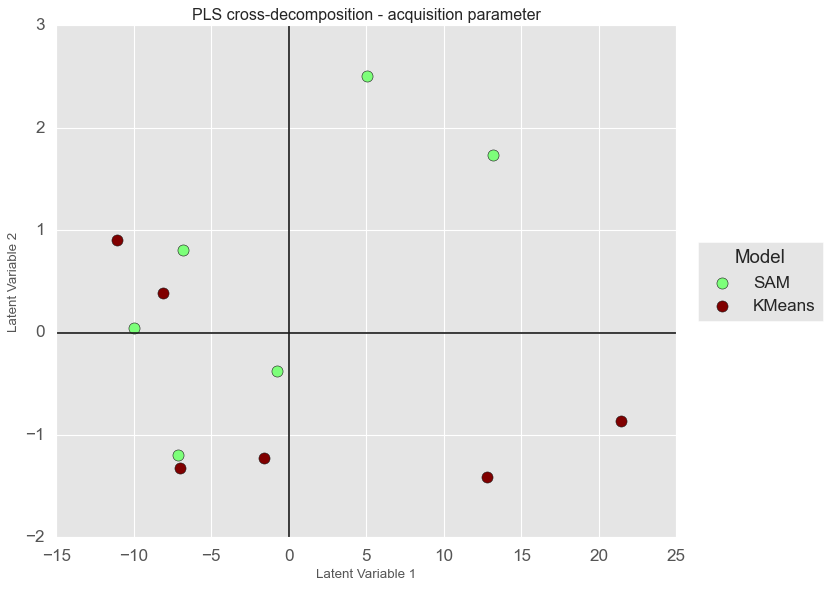

In [49]:
model_labels = all_predicted_spectra.index.get_level_values(0).astype('uint8')

pls_binary = PLSRegression(n_components = 2)
model_pls = pls_binary.fit_transform(all_predicted_spectra.values, model_labels)[0]

labels = ['SAM', 'KMeans']

# Scatter plot
unique = list(set(model_labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
 
with plt.style.context(('ggplot')):
    plt.figure(figsize=(10,8))
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [model_pls[j,0] for j in range(len(model_pls[:,0])) if model_labels[j] == u]
        yi = [model_pls[j,1] for j in range(len(model_pls[:,1])) if model_labels[j] == u]
        plt.scatter(xi, yi, c=col, s=100, edgecolors='k',label=str(u))
 
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.legend(labels, loc = 'center right', title = 'Model', scatterpoints = 1, bbox_to_anchor=(1.25, 0.5))
    plt.title('PLS cross-decomposition - acquisition parameter')
    plt.axhline(0, color = 'k')
    plt.axvline(0, color = 'k')
    plt.savefig('pls-da_bymodel.png', dpi=300, bbox_inches='tight')
    plt.show()

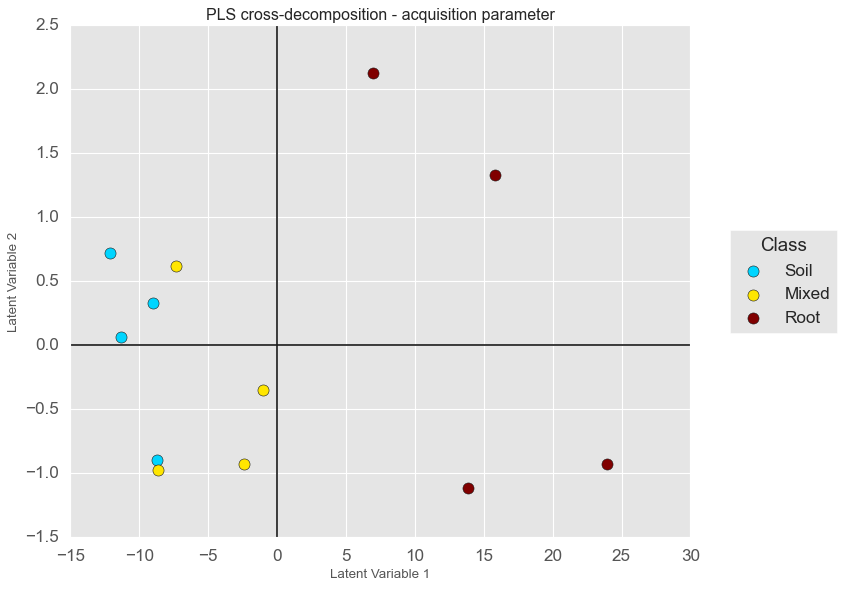

In [50]:
class_labels = all_predicted_spectra.index.get_level_values(3).astype('uint8')

pls_binary = PLSRegression(n_components = 2)
class_pls = pls_binary.fit_transform(all_predicted_spectra.values, class_labels)[0]

labels = ['Soil', 'Mixed', 'Root']

# Scatter plot
unique = list(set(class_labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
 
with plt.style.context(('ggplot')):
    plt.figure(figsize=(10,8))
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [class_pls[j,0] for j in range(len(class_pls[:,0])) if class_labels[j] == u]
        yi = [class_pls[j,1] for j in range(len(class_pls[:,1])) if class_labels[j] == u]
        plt.scatter(xi, yi, c=col, s=100, edgecolors='k',label=str(u))
 
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.legend(labels, loc = 'center right', title = 'Class', scatterpoints = 1, bbox_to_anchor=(1.25, 0.5))
    plt.title('PLS cross-decomposition - acquisition parameter')
    plt.axhline(0, color = 'k')
    plt.axvline(0, color = 'k')
    plt.savefig('pls-da_byclass.png', dpi=300, bbox_inches='tight')
    plt.show()

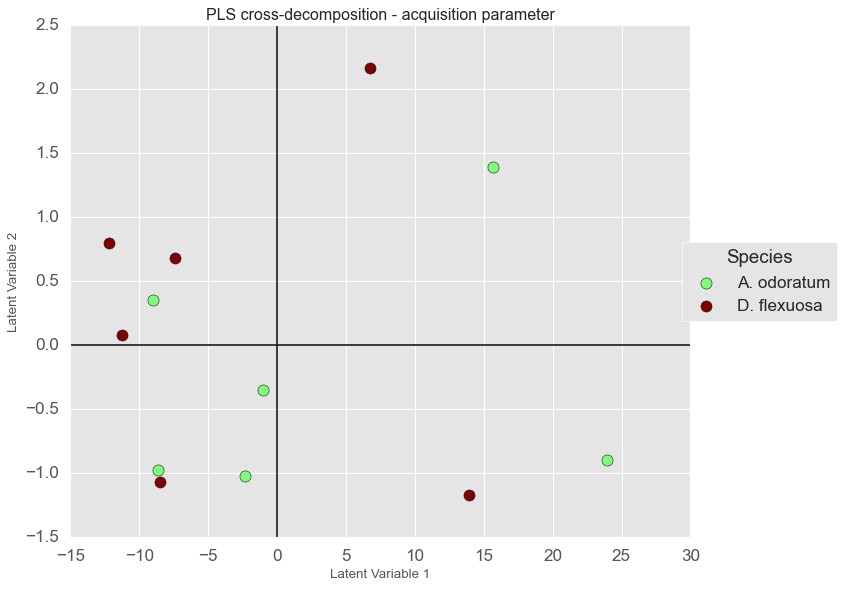

In [51]:
species_labels = all_predicted_spectra.index.get_level_values(4).astype('uint8')

pls_binary = PLSRegression(n_components = 2)
species_pls = pls_binary.fit_transform(all_predicted_spectra.values, species_labels)[0]

labels = ['A. odoratum', 'D. flexuosa']

# Scatter plot
unique = list(set(species_labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
 
with plt.style.context(('ggplot')):
    plt.figure(figsize=(10,8))
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [species_pls[j,0] for j in range(len(species_pls[:,0])) if species_labels[j] == u]
        yi = [species_pls[j,1] for j in range(len(species_pls[:,1])) if species_labels[j] == u]
        plt.scatter(xi, yi, c=col, s=100, edgecolors='k',label=str(u))
 
    plt.xlabel('Latent Variable 1')
    plt.ylabel('Latent Variable 2')
    plt.legend(labels, loc = 'center right', title = 'Species', scatterpoints = 1, bbox_to_anchor=(1.25, 0.5))
    plt.title('PLS cross-decomposition - acquisition parameter')
    plt.axhline(0, color = 'k')
    plt.axvline(0, color = 'k')
    plt.savefig('pls-da_byspecies.png', dpi=300, bbox_inches='tight')
    plt.show()